# Importing Libraries

In [1]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image
from random import randint

# pytorch libraries
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# to make the results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

set the **DATA_PATH** if you are not working on kaggle

In [2]:
DATA_PATH = "archive (6)"
print(os.listdir(DATA_PATH))

['.DS_Store', 'images', 'GroundTruth.csv', 'masks']


Read the csv file named as 'GroundTruth.csv' to access the data.

In [3]:
df=pd.read_csv(os.path.join(DATA_PATH,'GroundTruth.csv'))
print (df.head())
print (len(df))
print (df.columns)

          image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0
10015
Index(['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'], dtype='object')


The image column contains the file names of skin cancer images but the file extensions are missing so we should add the missing '.jpg' extensions.

In [4]:
df['image']=df['image'].apply(lambda x: x+ '.jpg')
print (df.head())

              image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309.jpg  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310.jpg  1.0  0.0  0.0    0.0  0.0  0.0   0.0


In [5]:
list(df.columns[1:])

['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

As we can see the lesion namees are shortened and encoded in our data.
We are changing the lesion names with more understandable names and giving an id to every type.

In [6]:
lesion_type_dict = {
    'NV': 'Melanocytic nevi',
    'MEL': 'Melanoma',
    'BKL': 'Benign keratosis like lesions',
    'BCC': 'Basal cell carcinoma',
    'AKIEC': 'Actinic keratoses',
    'VASC': 'Vascular lesions',
    'DF': 'Dermatofibroma'
}

labels = list(df.columns[1:])
label_list=[]
for i in range (len(df)):
    row= list(df.iloc[i])[1:]
    index=np.argmax(row)
    label=lesion_type_dict[labels[index]]
    label_list.append(label)
df['label']= label_list
df=df.drop(labels, axis=1)
df['label_idx'] = pd.Categorical(df['label']).codes
print(df.head())

              image             label  label_idx
0  ISIC_0024306.jpg  Melanocytic nevi          4
1  ISIC_0024307.jpg  Melanocytic nevi          4
2  ISIC_0024308.jpg  Melanocytic nevi          4
3  ISIC_0024309.jpg  Melanocytic nevi          4
4  ISIC_0024310.jpg          Melanoma          5


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      10015 non-null  object
 1   label      10015 non-null  object
 2   label_idx  10015 non-null  int8  
dtypes: int8(1), object(2)
memory usage: 166.4+ KB


In [8]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      10015 non-null  object
 1   label      10015 non-null  object
 2   label_idx  10015 non-null  int8  
dtypes: int8(1), object(2)
memory usage: 166.4+ KB


We tried to remove duplicates but there was no duplicate data

# Sample Image

We are looking at a random picture to sample the data. it shows different images in every run

(450, 600, 3)


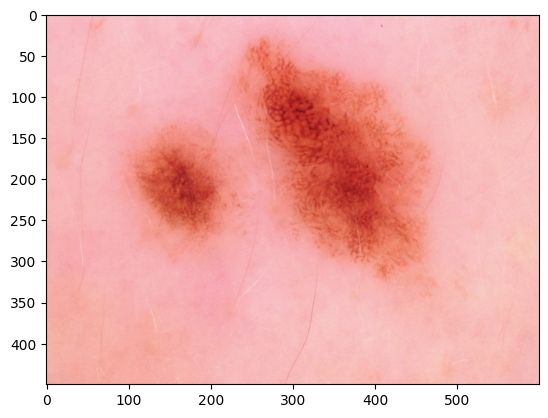

In [9]:
images_path = os.path.join(DATA_PATH,'images')
image_files = os.listdir(images_path)
random_file = image_files[randint(0,len(image_files)-1)]
random_file = os.path.join(images_path, random_file)
img=plt.imread(random_file)
print (img.shape)
plt.imshow(img)

# Train Test Split

We are setting the
* Train Size: %90
* Validation/Dev Size: %2.5
* Test Size: %7.5



Changing to 90, 1, 1.

This threw - InvalidParameterError: The 'train_size' parameter of train_test_split must be a float in the range (0.0, 1.0), an int in the range [1, inf) or None. Got 1.0000000000000002 instead.

so using round() to get rid of floats

This actually made it worse so changing it back

In [10]:
train_split=.9 # set this to the percentof the data you want to use for training
valid_split=.025 # set this to the percent of the data you want to use for validation
# Note percent of data sed for test is 1-train_split-valid_split

valid_split=valid_split/(1-train_split)
train_test_split
train_df, val_test_df = train_test_split(df, train_size=train_split, random_state=62)
val_df, test_df = train_test_split(val_test_df, train_size=valid_split, random_state=62)
print('Data Len Train:', len(train_df), 'Val:', len(val_df), 'Test:', len(test_df))


Data Len Train: 9013 Val: 250 Test: 752


Let us check the data distribution by labels

In [11]:
print (train_df['label'].value_counts())

label
Melanocytic nevi                 6046
Melanoma                         1006
Benign keratosis like lesions     986
Basal cell carcinoma              460
Actinic keratoses                 286
Vascular lesions                  128
Dermatofibroma                    101
Name: count, dtype: int64


Train dataset is highly out of balance. So limit maximum samples per class to 450 samples for balancing it.

In [12]:
max_size=450 # set maximum number of samples for each class
samples=[]
group=train_df.groupby('label')
for label in train_df['label'].unique():
    Lgroup=group.get_group(label)
    count=int(Lgroup['label'].value_counts())    
    if count>=max_size:
        sample=Lgroup.sample(max_size, axis=0)        
    else:        
        sample=Lgroup.sample(frac=1, axis=0)
    samples.append(sample) 
train_df=pd.concat(samples, axis=0).reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(train_df['label'].value_counts())  

label
Melanocytic nevi                 450
Benign keratosis like lesions    450
Basal cell carcinoma             450
Melanoma                         450
Actinic keratoses                286
Vascular lesions                 128
Dermatofibroma                   101
Name: count, dtype: int64


/var/folders/y6/8nc96cw14916ctrbmk6g9_mc0000gn/T/ipykernel_24723/907093615.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  count=int(Lgroup['label'].value_counts())
/var/folders/y6/8nc96cw14916ctrbmk6g9_mc0000gn/T/ipykernel_24723/907093615.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  count=int(Lgroup['label'].value_counts())
/var/folders/y6/8nc96cw14916ctrbmk6g9_mc0000gn/T/ipykernel_24723/907093615.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  count=int(Lgroup['label'].value_counts())
/var/folders/y6/8nc96cw14916ctrbmk6g9_mc0000gn/T/ipykernel_24723/907093615.py:6: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[

We already computed and set the variables for normalizing the images. If you want to re-compute them, just remove the code comments at the end of cell below.

In [13]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)
        
    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

norm_mean = [0.76303685, 0.54564613, 0.570045]
norm_std = [0.14092818, 0.15261282, 0.16997021]
# image_paths = glob(os.path.join(DATA_PATH,'images','*.jpg'))
# norm_mean,norm_std = compute_img_mean_std(image_paths)

# Prepare DataLoaders

We are setting transformations for train and validation/test datasets. They are different because we want to rotate or flip the data in training to diversify the data.

In [14]:
# define the transformation of the train images.
# edited this for better accuracy https://pytorch.org/vision/main/transforms.html
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomVerticalFlip(p=0.5),  # Random vertical flip
    transforms.RandomRotation(degrees=30),  # Rotate up to 30 degrees
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),  # Random crop and resize
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Simulate lighting variations
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Slight translation
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Apply slight blur for robustness
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(norm_mean, norm_std)  # Normalize based on dataset mean and std
])
# define the transformation of the val and test images.
val_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

We have worked with the pandas library so far, but we need to change our data type in order to feed it to our model in batches.

In [15]:
# Define a pytorch dataloader for this dataset
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(os.path.join(DATA_PATH, 'images', self.df['image'][index]))
        y = torch.tensor(int(self.df['label_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

The data loaders handles batches for us

In [16]:
BATCH_SIZE = 64
NUM_WORKERS =  0 # Changed from 2 to 0 as error showed when training - https://towardsdatascience.com/ml-engineering-101-a-thorough-explanation-of-the-error-dataloader-worker-pid-s-xxx-exited-f3a6a983911e/?utm_source=chatgpt.com

# Define the training,val,test sets using the tables and using our defined transitions
train_set = HAM10000(train_df, transform=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

val_set = HAM10000(val_df, transform=val_transform)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

test_set = HAM10000(test_df, transform=val_transform)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print('Data Len Train:', len(train_set), 'Val:', len(val_set), 'Test:', len(test_set))

Data Len Train: 2315 Val: 250 Test: 752


# Preparing Models

In the cell below we are creating a simple conv net for 6 class classification problem

In [17]:
class mySimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

print(mySimpleNet())

mySimpleNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=6, bias=True)
)


We are creating a model select function to get a model from four options with one parameter change. It is editing the last layer as our class count.

In [18]:
# feature_extract is a boolean that defines if we are finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)


    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
    
    elif model_name == "densenet":
        """ Densenet121
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == "customnet":
        """ Our Custom CNN Model"""
        model_ft = mySimpleNet()
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc3.in_features
        model_ft.fc3 = nn.Linear(num_ftrs, num_classes)
    
    else:
        print("Invalid model name, exiting...")
        exit()
    return model_ft

Preparing the train and validation functions

In [19]:
class AverageMeter(object):
    """Computes and stores the epochs average and current value in batches"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val):
        self.val = val
        self.sum += val
        self.count += 1
        self.avg = self.sum / self.count
        
        
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        if (i + 1) % 10 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
    return train_loss.avg, train_acc.avg

def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

We can change model by only changing model_name variable.
The selected models layers will be printed out after model is ready.

In [20]:
# resnet,vgg,densenet,customnet
model_name = 'resnet'




num_classes = len(train_df['label'].unique())
feature_extract = False
# Initialize the model for this run
model_ft = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
print(model_ft)
# Define the device:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #moved to local cpu
print(f"Using device: {device}")
# Put the model on the device:
model = model_ft.to(device)

/opt/miniconda3/envs/aim/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/miniconda3/envs/aim/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Training

We are starting to train by setting number of epochs and learning rate.
To mention, we used **CrossEntropyLoss** as the loss function and the **Adam Optimizer** as the optimizer.

In [21]:
epoch_num = 100 #Increased for better accuracy
learning_rate = 3e-4 #Lower due to overfitting (ChatGPT)


best_val_acc = 0
total_loss_val, total_acc_val = [],[]
total_loss_train, total_acc_train = [],[]

# we use Adam optimizer, use cross entropy loss as our loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss().to(device)

for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    total_loss_train.append(loss_train)
    total_acc_train.append(acc_train)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 10 / 37], [train loss 1.54048], [train acc 0.40000]
[epoch 1], [iter 20 / 37], [train loss 1.42015], [train acc 0.44922]
[epoch 1], [iter 30 / 37], [train loss 1.31214], [train acc 0.49375]
------------------------------------------------------------
[epoch 1], [val loss 0.92553], [val acc 0.67241]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.92553], [val acc 0.67241]
*****************************************************
[epoch 2], [iter 10 / 37], [train loss 1.22505], [train acc 0.55000]
[epoch 2], [iter 20 / 37], [train loss 1.16082], [train acc 0.56875]
[epoch 2], [iter 30 / 37], [train loss 1.12479], [train acc 0.57708]
------------------------------------------------------------
[epoch 2], [val loss 0.78557], [val acc 0.72158]
------------------------------------------------------------
*****************************************************
best record: [epoch 

### Print And Plot The Results

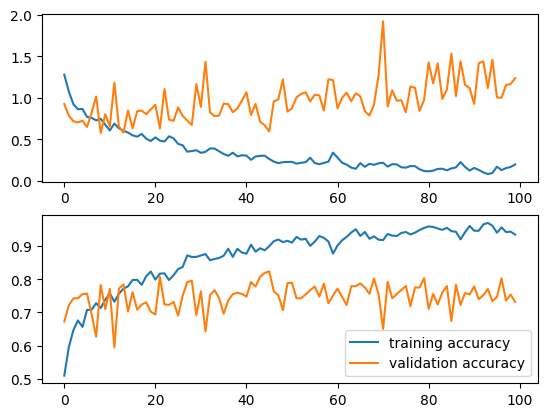

In [22]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_loss_val, label = 'validation loss')

fig2.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_acc_val, label = 'validation accuracy')
plt.legend()
plt.show()

# Testing Our Model With Test Data

In [23]:
loss_test, acc_test = validate(test_loader, model, criterion, optimizer, 1)

------------------------------------------------------------
[epoch 1], [val loss 1.19750], [val acc 0.71224]
------------------------------------------------------------


In [24]:
plot_labels = list(df[['label', 'label_idx']].drop_duplicates().sort_values(by='label_idx')['label'])
print({ind: val for ind,val in enumerate(plot_labels)})

{0: 'Actinic keratoses', 1: 'Basal cell carcinoma', 2: 'Benign keratosis like lesions', 3: 'Dermatofibroma', 4: 'Melanocytic nevi', 5: 'Melanoma', 6: 'Vascular lesions'}


In [25]:
model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# Generate a classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

                               precision    recall  f1-score   support

            Actinic keratoses       0.51      0.53      0.52        34
         Basal cell carcinoma       0.59      0.77      0.67        35
Benign keratosis like lesions       0.53      0.70      0.60        96
               Dermatofibroma       0.30      0.75      0.43         8
             Melanocytic nevi       0.97      0.71      0.82       490
                     Melanoma       0.40      0.76      0.53        78
             Vascular lesions       0.52      1.00      0.69        11

                     accuracy                           0.71       752
                    macro avg       0.55      0.75      0.61       752
                 weighted avg       0.81      0.71      0.74       752



In [26]:
torch.save(model.state_dict(), "skin_cancer_model.pth")
#save to path